# Симуляция

Добавим необходимые импорты модулей и определения процедур.

Для симуляции создадим взвешенный граф. Веса рёбер будут означать долю полетов по данному маршруту.

Для целей отладки/сокращения времени вычислений добавим параметр step шаг (в процедуру запуска симуляции `run_simulation`), чтобы можно было обрабатывать не весь dataset, а частично — с каким-то шагом. Если задать step=1, то будут обработаны все записи dataset без исключения.

In [1]:
from datetime import datetime
from math import *
from random import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


np.random.seed(7)


def load_len_of_df(file_name):
    with open(file_name) as file_in:
        return int(file_in.readline())
    

def load_first_datetime(file_name):
    with open(file_name) as file_in:
        return datetime.strptime(file_in.readline(), '%Y-%m-%d %H:%M:%S')
    

def get_event(file_name):
    for chunk in pd.read_csv(file_name, chunksize=1000, iterator=True):
      for record in chunk.itertuples():
          yield (record.Origin, record.Dest, datetime.strptime(record.DateTime, '%Y-%m-%d %H:%M:%S'))


def create_graph(filename_labels):
    G = nx.Graph()
    
    with open(filename_labels) as f_in:
        for label in f_in.readline().split(', '):
            G.add_node(label) # Add nodes based on names from csv file
            G.nodes[label]['epidemic_status'] = False
                
    return G


def init_draw(G):
    node_colors = get_node_colors(G)
    fig,ax = plt.subplots(1, figsize=(18, 10))
    plt.axis('off')

    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos, ax=ax, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, ax=ax)
    display(fig)
    clear_output(wait=True)

    return fig, ax, pos


def redraw(G, ax, pos, fig):
    node_colors = get_node_colors(G)
    ax.clear()
    nx.draw_networkx(G, pos=pos, ax=ax, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.3, arrowstyle='->', ax=ax)
    display(fig)
    clear_output(wait=True)


def convert_dictlog_to_list(dict_log):
    result = []

    with open('2008_cityNames.txt') as f_in:
        total = len(f_in.readline().split(', '))
    
    accum = 0
    for k, v in dict_log.items():
        accum = accum + v
        result.append((k, 100 * accum / total))

    return result


def plot_temp_percent_diagram(dict_log, p):
    list_log = convert_dictlog_to_list(dict_log)

    df = pd.DataFrame(list_log, columns=['Time', 'Value'])

    #df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %p")

    plt.figure(figsize=(18,6)) # Create a new figure window
    plt.plot(df['Time'], df["Value"], marker='o') # Plot Value against Time
    plt.title('p = ' + str(p))
    plt.xlabel("Time")
    plt.ylabel("Percent")
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def add_edge_to_graph(G, origin, dest, total_flights):
    if G.has_edge(origin, dest):
        #print(origin, dest, G[origin][dest]['weight'])
        G[origin][dest]['weight'] = G[origin][dest]['weight'] + 1.0 / total_flights
    else:
        G.add_edge(origin, dest, weight=1)


def add_edge_and_redraw(G, ax, pos, fig, origin, dest, total_flights):
    add_edge_to_graph(G, origin, dest, total_flights)
    redraw(G, ax, pos, fig)


def get_node_colors(G):
    node_colors = ['r' if G.nodes[node]['epidemic_status'] else 'c' for node in G.nodes]
    return node_colors


def dict2text(d):
    return '\n'.join([f"{k}: {str(v)}" for k, v in d.items()])


def print_first_lines(txt, n):
    lines = txt.split('\n')
    for i in range(min(n, len(lines))):
        print(lines[i])


def round_datetime_to_ampm(dt):
    date_str = dt.strftime('%Y-%m-%d')
    ampm = 'AM' if dt.hour < 12 else 'PM'
    result = f"{date_str} {ampm}"
    return result


def average_dict_results(list_of_dicts):
    results = {}

    # Заполним общий словарь кол-вами городов
    for d in list_of_dicts:
        for k, v in d.items():
            if k in results:
                results[k] = results[k] + len(v)
            else:
                results[k] = len(v)

    # Запишем средние значения
    total_number_of_dicts = len(list_of_dicts)

    for k, v in results.items():
        results[k] = results[k] / total_number_of_dicts

    return results


# Процедура выполнения симуляции.
# Входные параметры: 
# startCity — начальный заражённый город;
# step — шаг с каким выбираются записи из dataset;
# redraw_in_process — периодически перерисовывать картинку в процессе симуляции;
# draw_results — выводить ли вообще изображения (если False, то процедура не будет строить изображений).
def run_simulation(startCity, epidemicTimeForStartCity, p, step=1, redraw_in_process=True, draw_results=True):
    # Будем записывать в результаты список городов,
    # которые были заражены в указанную дату.
    results = {round_datetime_to_ampm(epidemicTimeForStartCity): [startCity, ]} 

    if not draw_results: redraw_in_process = False

    len_of_df = load_len_of_df('2008_numberOfRecords.txt')
    
    G = create_graph('2008_cityNames.txt')
    print('nodes: ', G.number_of_nodes())

    G.nodes[startCity]['epidemic_status'] = True

    if draw_results:
        fig, ax, pos = init_draw(G)

    gen_get_event = get_event('2008_with_date_sorted.csv')

    i = 0
    for _ in tqdm(range(0, len_of_df, step)): # Цикл симуляции
        fly = next(gen_get_event) # выбираем следующую запись из dataset

        # Для заражения нужен зараженный аэропорт-источник и незараженный аэропорт-приёмник:
        if G.nodes[fly[0]]['epidemic_status'] and not G.nodes[fly[1]]['epidemic_status']:
            if random() < p: # заражение произошло
                G.nodes[fly[1]]['epidemic_status'] = True
                date_fly = round_datetime_to_ampm(fly[2])

                if date_fly in results:
                    results[date_fly].append(fly[1])
                else:
                    results[date_fly] = [fly[1],]

        # если нужно, чтобы в процессе отображались промежуточные картики
        if redraw_in_process and i % 5000 == 0: 
            clear_output(wait=True)
            display(fig)
            add_edge_and_redraw(G, ax, pos, fig, fly[0], fly[1], len_of_df)
        else: # иначе без отображения промежуточных картинок
            add_edge_to_graph(G, fly[0], fly[1], len_of_df)

        i = i + 1

    if draw_results:
        redraw(G, ax, pos, fig)
    
    return results


def run_multiple_simulation(startCity, epidemicTimeForStartCity, p, step, n):
    results = []
    for i in tqdm(range(n)):
        dict_results = run_simulation(startCity, epidemicTimeForStartCity, p, step, 
                                    redraw_in_process=False, draw_results=(i == 0))
        results.append(dict_results)

    dict_avg_results = average_dict_results(results)
    plot_temp_percent_diagram(dict_avg_results, p)

Проверим выполнение симуляции. Список всех названий городов (коды аэропортов) находится в файле: 2008_cityNames.txt — зададим стартовый город.

2008-01-01 AM: ['ONT']
2008-01-01 PM: ['MRY', 'PHX', 'DEN', 'ASE', 'LAX', 'CVG', 'DTW', 'IND', 'SEA', 'MSP', 'ABQ', 'DFW', 'ORD', 'AVL', 'TUL', 'BTR', 'SNA', 'SAT', 'SAN', 'OAK', 'PVD', 'BWI', 'BIS', 'ATL', 'LGA', 'MCO', 'SMF', 'RSW', 'DCA', 'MLI', 'GGG', 'IAH', 'ISP', 'ELP', 'LAS', 'SLC', 'CLT', 'AUS', 'PHF', 'MDW', 'TYS', 'MSY', 'SJU', 'FAT', 'JFK', 'CLE', 'HDN', 'STL', 'IAD', 'FLL', 'PHL', 'MGM', 'DAB', 'FNT', 'EWR', 'RNO', 'SUN', 'BUF', 'LFT', 'RDU', 'MIA', 'SFO', 'BUR', 'MOB', 'PIT', 'SBA', 'SDF', 'LGB', 'BOS', 'TPA', 'GSO', 'ABI', 'MHT', 'BNA', 'CHS', 'HSV', 'GRB', 'DAL', 'MCI', 'MKE', 'SJC', 'IDA', 'HOU', 'BHM', 'SHV', 'ICT', 'PDX', 'MAF', 'LIT', 'CRP', 'OKC', 'FSD', 'MEM', 'SUX', 'BOI', 'OMA', 'CID', 'BDL', 'CAK', 'EGE', 'OGG', 'JAX', 'KOA', 'AMA', 'TWF', 'SPS', 'ORF', 'HNL', 'TOL', 'SAV', 'ATW', 'LNK', 'CMH', 'PSP', 'FSM', 'ILM', 'SCE', 'LCH', 'CAE', 'JAN', 'CIC', 'AZO', 'GEG', 'MSO', 'FAR', 'SWF', 'TUP', 'TVC', 'CRW', 'COS', 'IYK', 'IPL', 'SBP', 'SBN', 'PSC', 'RST', 'RIC', 'A

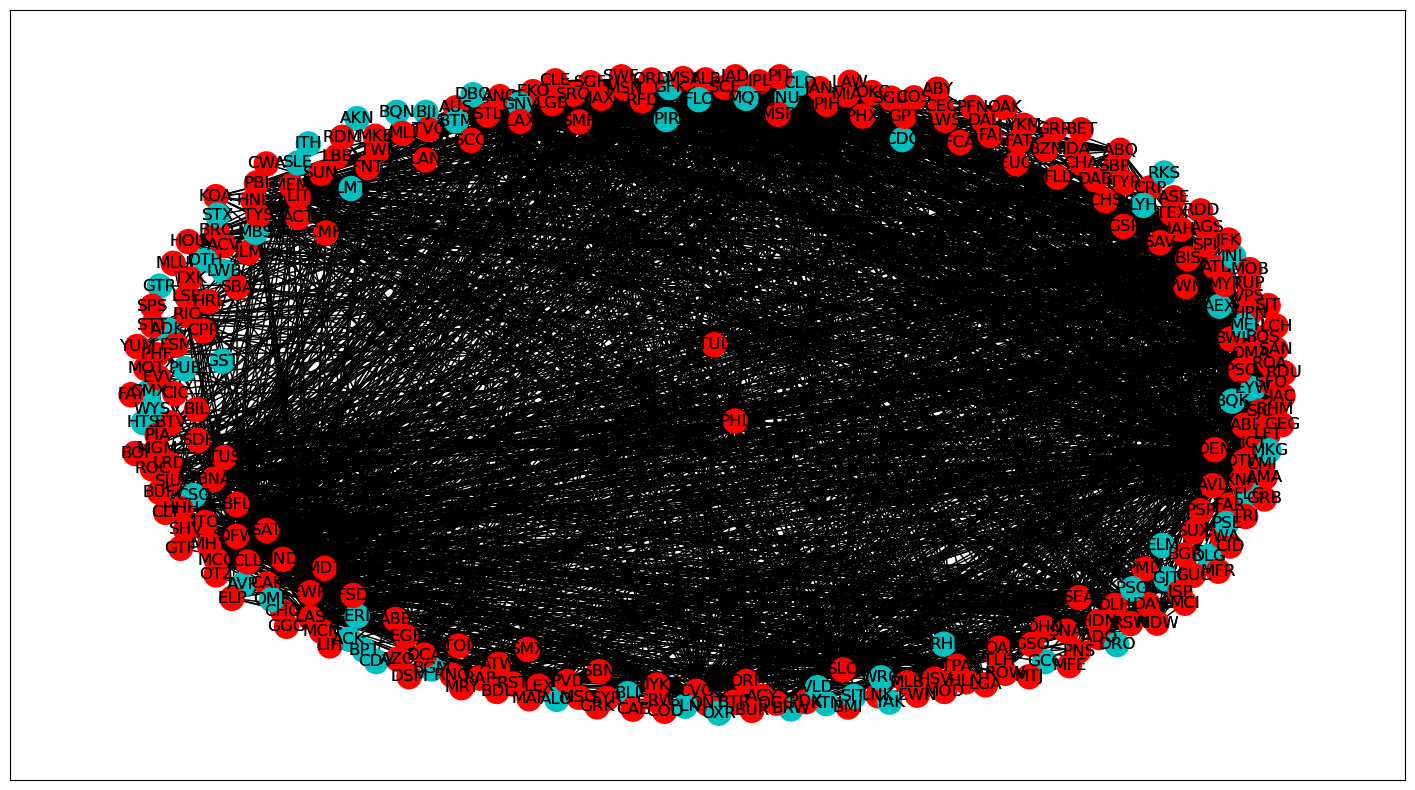

In [85]:
startCity = 'ONT'
epidemicTimeForStartCity = load_first_datetime('2008_firstDateTime.txt') # Время заражения первого аэропорта
p = 0.1
#step = 1 # Full dataset
step =100 # For debug and develoging

dict_results = run_simulation(startCity, epidemicTimeForStartCity, p, step, redraw_in_process=False)
print_first_lines(dict2text(dict_results), 5)

## Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?


 10%|█         | 1/10 [01:29<13:26, 89.65s/it]

nodes:  303


 20%|██        | 2/10 [02:57<11:51, 88.88s/it]

nodes:  303


 30%|███       | 3/10 [04:23<10:11, 87.30s/it]

nodes:  303


 40%|████      | 4/10 [05:47<08:36, 86.12s/it]

nodes:  303


 50%|█████     | 5/10 [07:12<07:07, 85.46s/it]

nodes:  303


 60%|██████    | 6/10 [08:36<05:40, 85.14s/it]

nodes:  303


 70%|███████   | 7/10 [10:00<04:14, 84.90s/it]

nodes:  303


 80%|████████  | 8/10 [11:28<02:51, 85.70s/it]

nodes:  303


 90%|█████████ | 9/10 [12:52<01:25, 85.14s/it]

nodes:  303


100%|██████████| 10/10 [14:16<00:00, 85.63s/it]


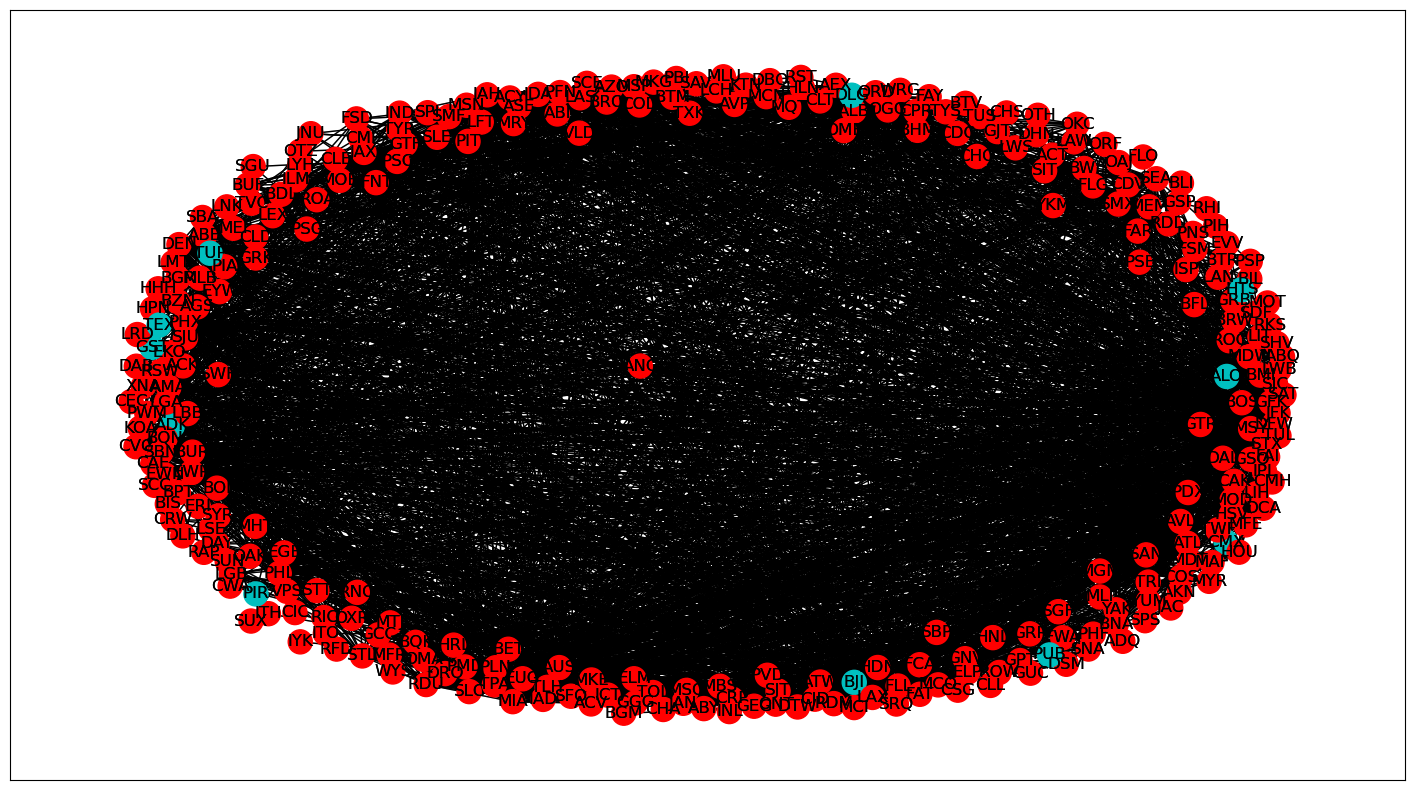

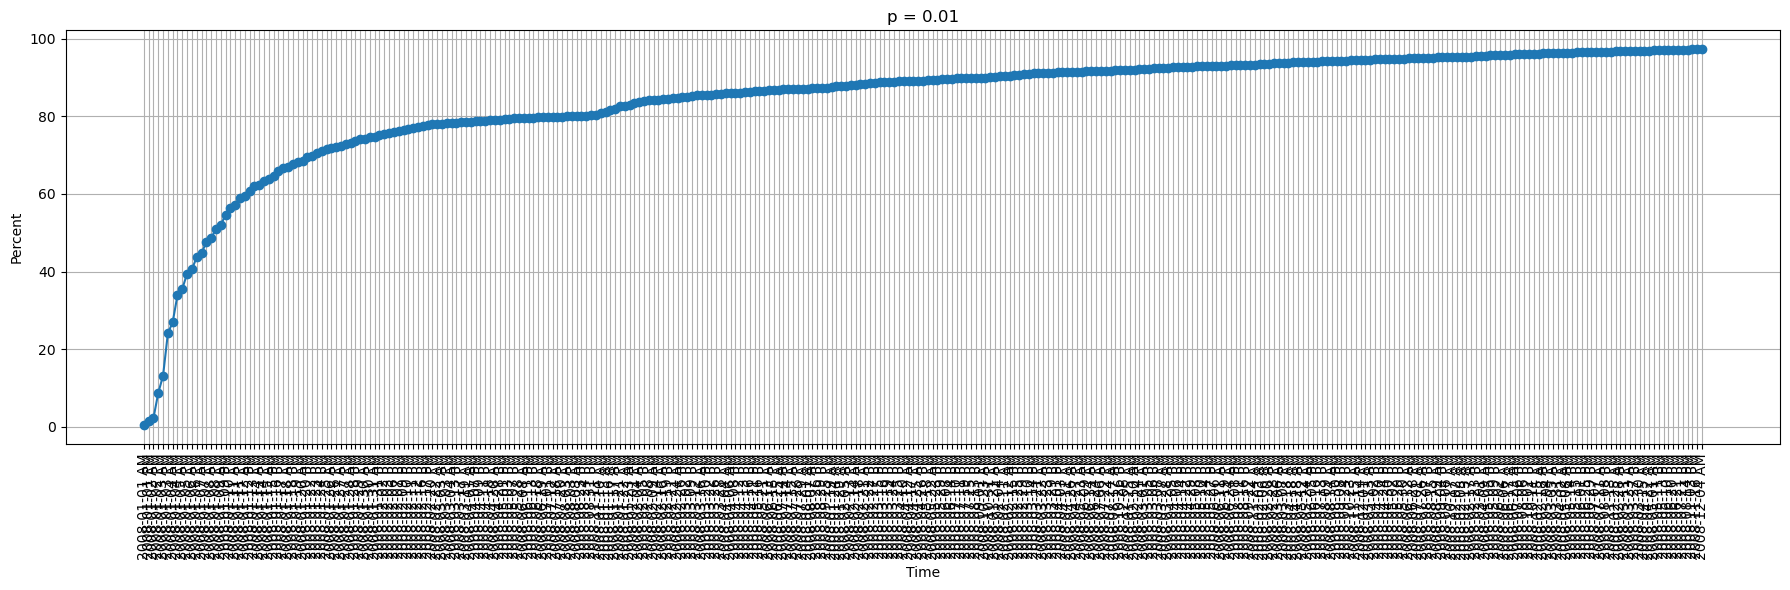

In [2]:
p = 0.01
startCity = 'ONT'
epidemicTimeForStartCity = load_first_datetime('2008_firstDateTime.txt') # Время заражения первого аэропорта
step = 1 # Full dataset
#step =100 # For debug and develoging
n = 10 # Число запусков для усреднения

run_multiple_simulation(startCity, epidemicTimeForStartCity, p, step, n)


 10%|█         | 1/10 [01:26<12:57, 86.41s/it]

nodes:  303


 20%|██        | 2/10 [02:51<11:24, 85.58s/it]

nodes:  303


 30%|███       | 3/10 [04:15<09:55, 85.12s/it]

nodes:  303


 40%|████      | 4/10 [05:40<08:29, 84.88s/it]

nodes:  303


 50%|█████     | 5/10 [07:05<07:04, 84.84s/it]

nodes:  303


 60%|██████    | 6/10 [08:29<05:39, 84.77s/it]

nodes:  303


 70%|███████   | 7/10 [09:54<04:14, 84.80s/it]

nodes:  303


 80%|████████  | 8/10 [11:19<02:49, 84.86s/it]

nodes:  303


 90%|█████████ | 9/10 [12:44<01:24, 84.89s/it]

nodes:  303


100%|██████████| 10/10 [14:09<00:00, 84.94s/it]


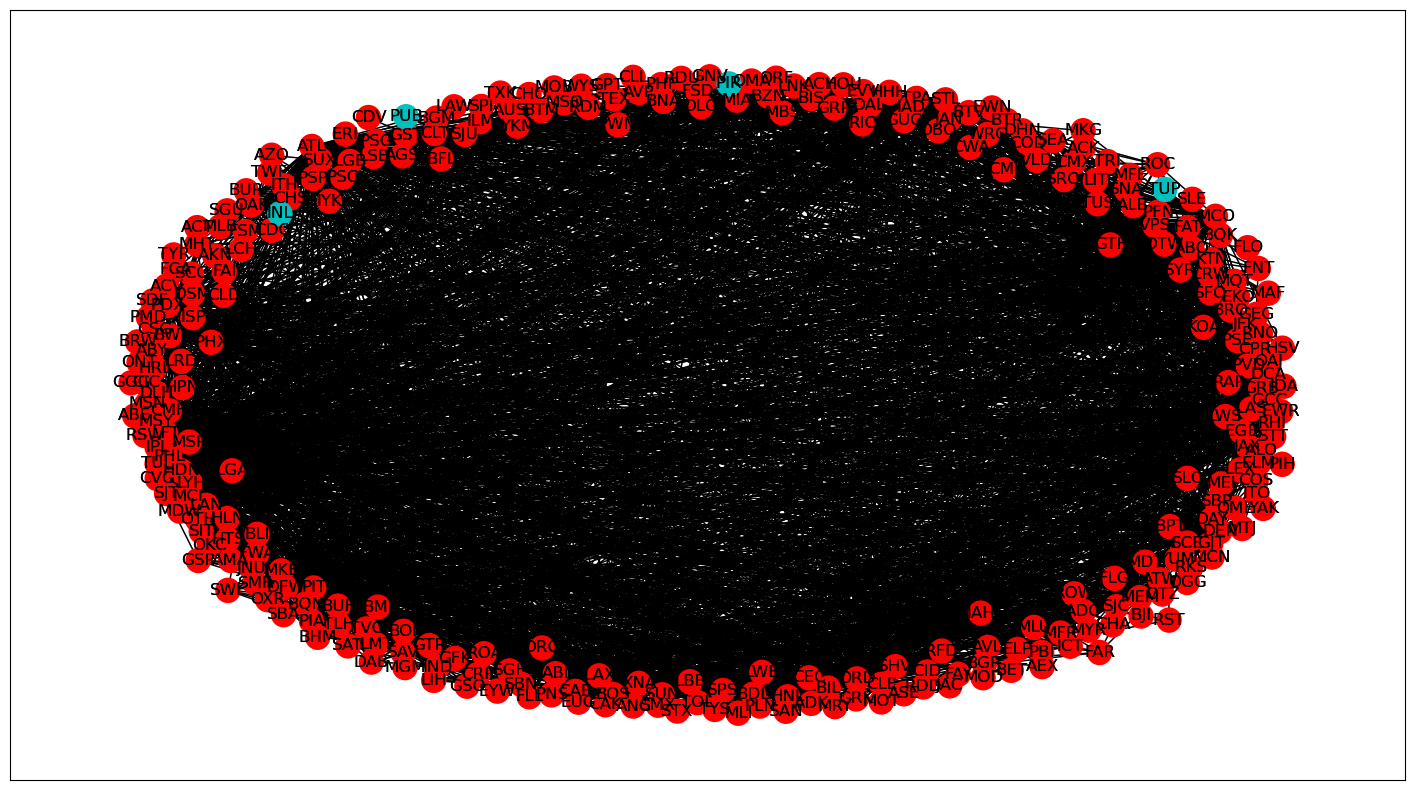

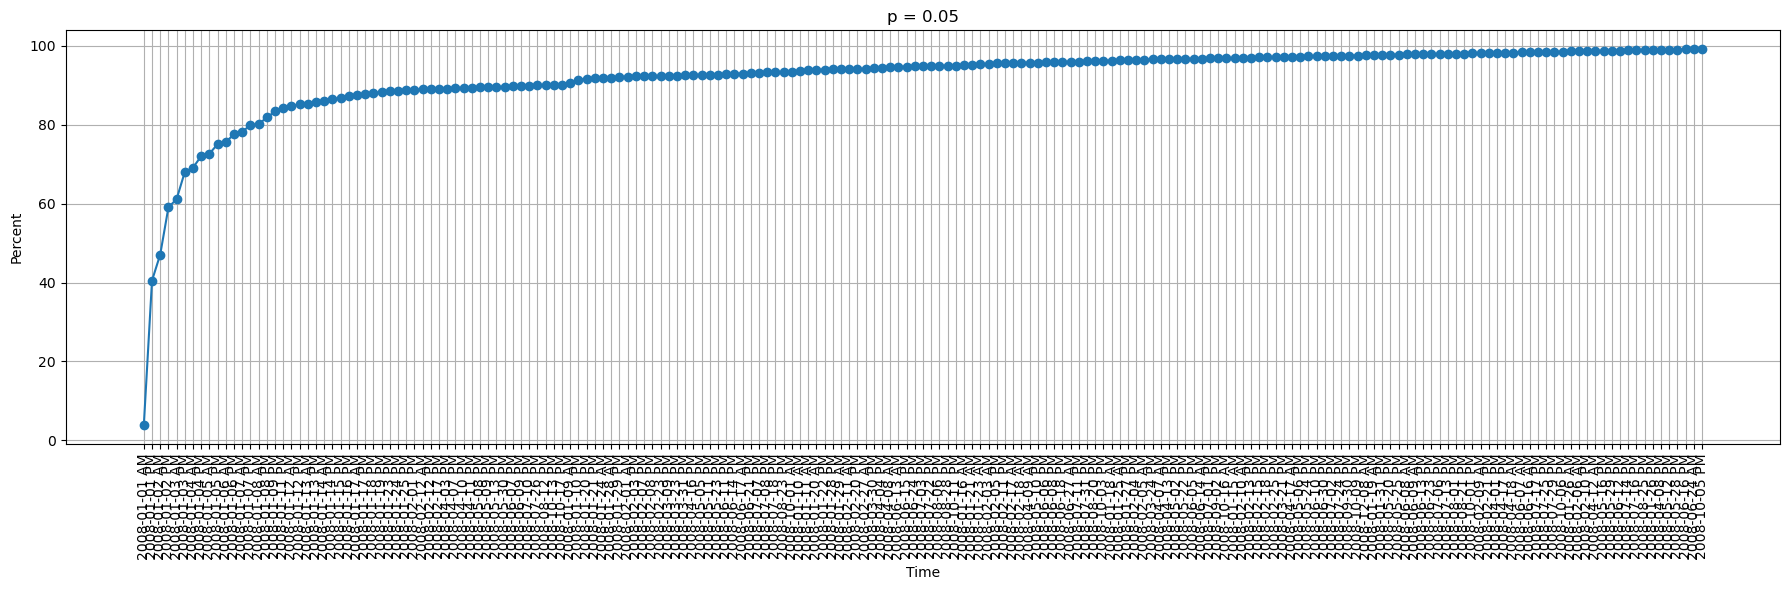

In [3]:
p = 0.05
run_multiple_simulation(startCity, epidemicTimeForStartCity, p, step, n)


 10%|█         | 1/10 [01:26<12:55, 86.14s/it]

nodes:  303


 20%|██        | 2/10 [02:51<11:23, 85.42s/it]

nodes:  303


 30%|███       | 3/10 [04:16<09:56, 85.21s/it]

nodes:  303


 40%|████      | 4/10 [05:40<08:29, 84.91s/it]

nodes:  303


 50%|█████     | 5/10 [07:05<07:04, 84.85s/it]

nodes:  303


 60%|██████    | 6/10 [08:29<05:38, 84.75s/it]

nodes:  303


 70%|███████   | 7/10 [09:54<04:14, 84.73s/it]

nodes:  303


 80%|████████  | 8/10 [11:19<02:49, 84.72s/it]

nodes:  303


 90%|█████████ | 9/10 [12:43<01:24, 84.72s/it]

nodes:  303


100%|██████████| 10/10 [14:08<00:00, 84.88s/it]


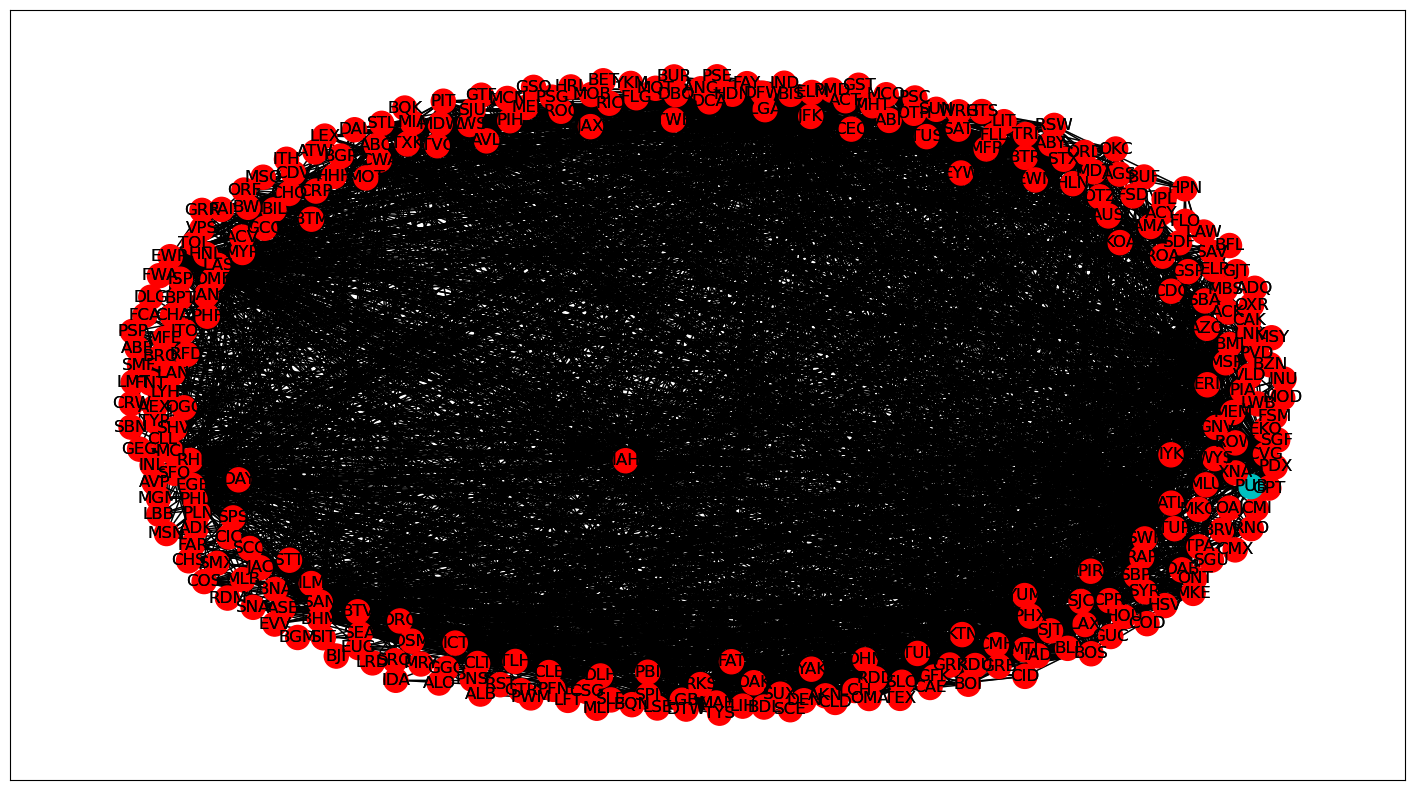

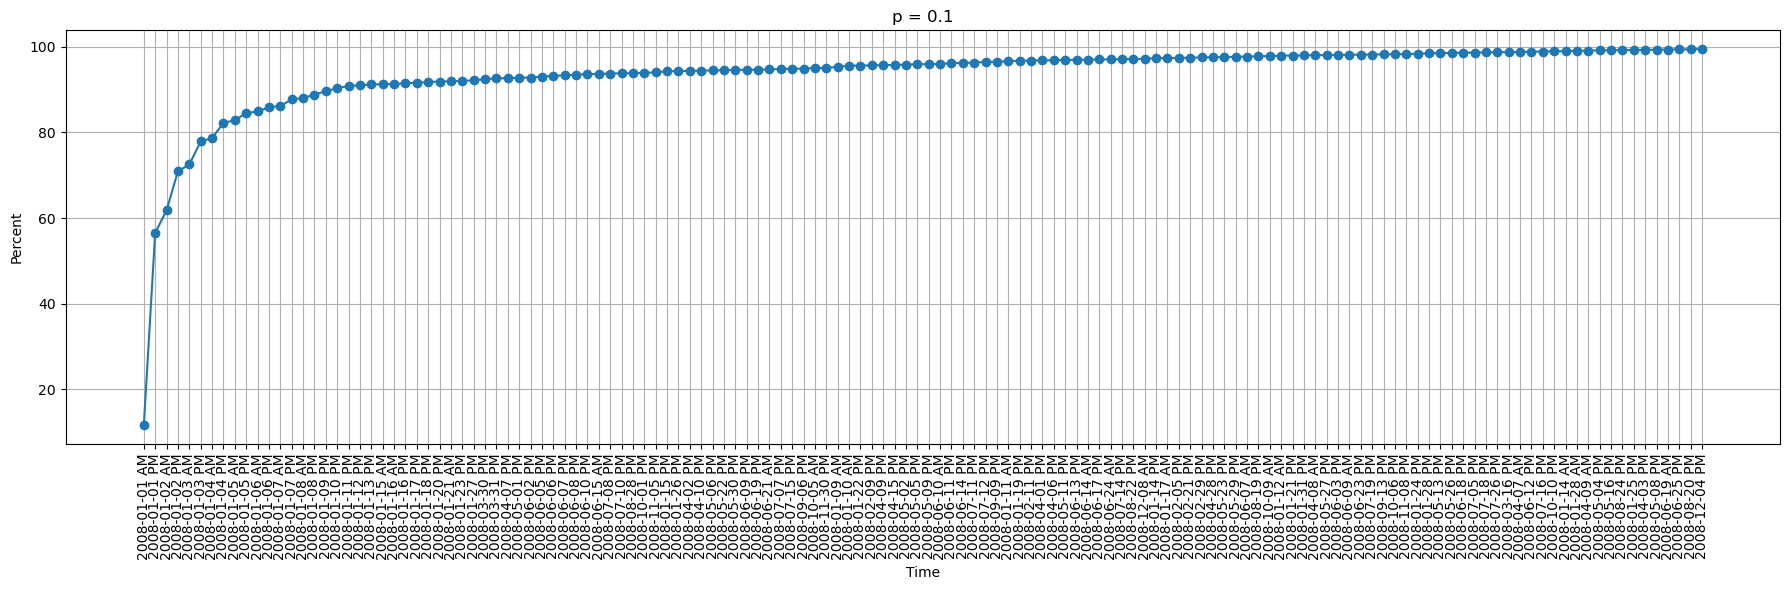

In [4]:
p = 0.1
run_multiple_simulation(startCity, epidemicTimeForStartCity, p, step, n)


 10%|█         | 1/10 [01:25<12:52, 85.84s/it]

nodes:  303


 20%|██        | 2/10 [02:50<11:19, 84.95s/it]

nodes:  303


 30%|███       | 3/10 [04:14<09:52, 84.62s/it]

nodes:  303


 40%|████      | 4/10 [05:38<08:27, 84.51s/it]

nodes:  303


 50%|█████     | 5/10 [07:02<07:01, 84.38s/it]

nodes:  303


 60%|██████    | 6/10 [08:27<05:37, 84.33s/it]

nodes:  303


 70%|███████   | 7/10 [09:51<04:12, 84.33s/it]

nodes:  303


 80%|████████  | 8/10 [11:15<02:48, 84.37s/it]

nodes:  303


 90%|█████████ | 9/10 [12:40<01:24, 84.41s/it]

nodes:  303


100%|██████████| 10/10 [14:05<00:00, 84.51s/it]


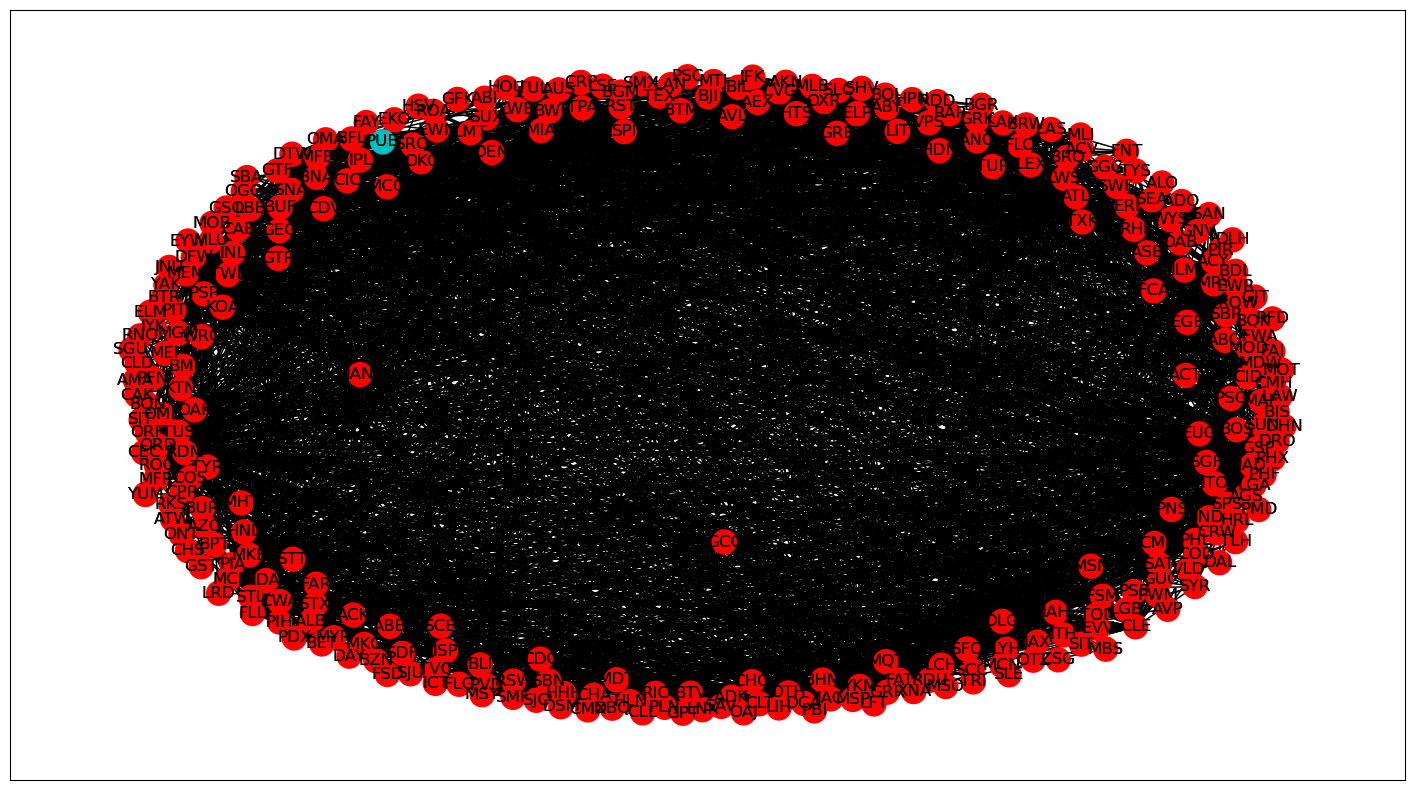

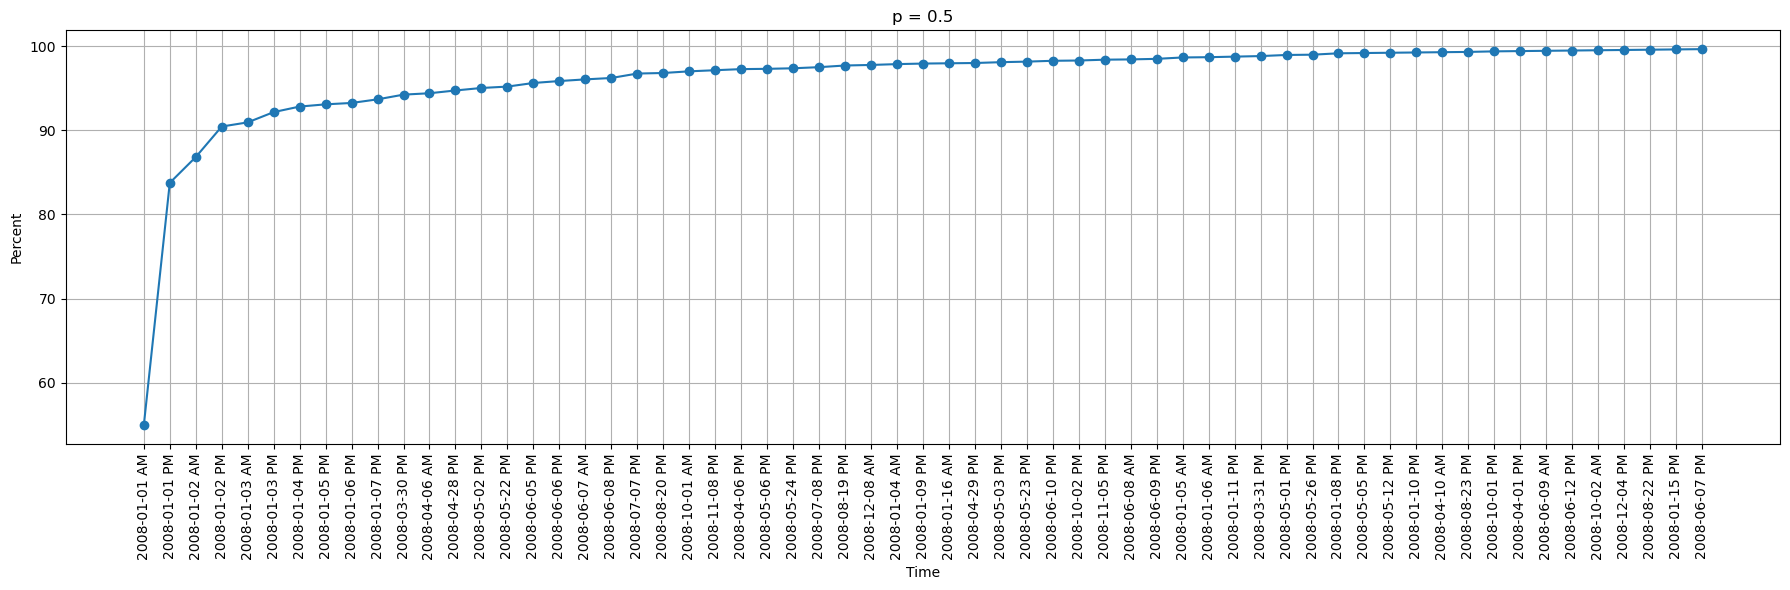

In [5]:
p = 0.5
run_multiple_simulation(startCity, epidemicTimeForStartCity, p, step, n)


 10%|█         | 1/10 [01:27<13:04, 87.21s/it]

nodes:  303


 20%|██        | 2/10 [02:54<11:40, 87.55s/it]

nodes:  303


 30%|███       | 3/10 [04:22<10:12, 87.51s/it]

nodes:  303


 40%|████      | 4/10 [05:50<08:47, 87.92s/it]

nodes:  303


 50%|█████     | 5/10 [07:15<07:13, 86.70s/it]

nodes:  303


 60%|██████    | 6/10 [08:40<05:44, 86.14s/it]

nodes:  303


 70%|███████   | 7/10 [10:05<04:17, 85.70s/it]

nodes:  303


 80%|████████  | 8/10 [11:29<02:50, 85.34s/it]

nodes:  303


 90%|█████████ | 9/10 [12:54<01:25, 85.10s/it]

nodes:  303


100%|██████████| 10/10 [14:19<00:00, 85.97s/it]


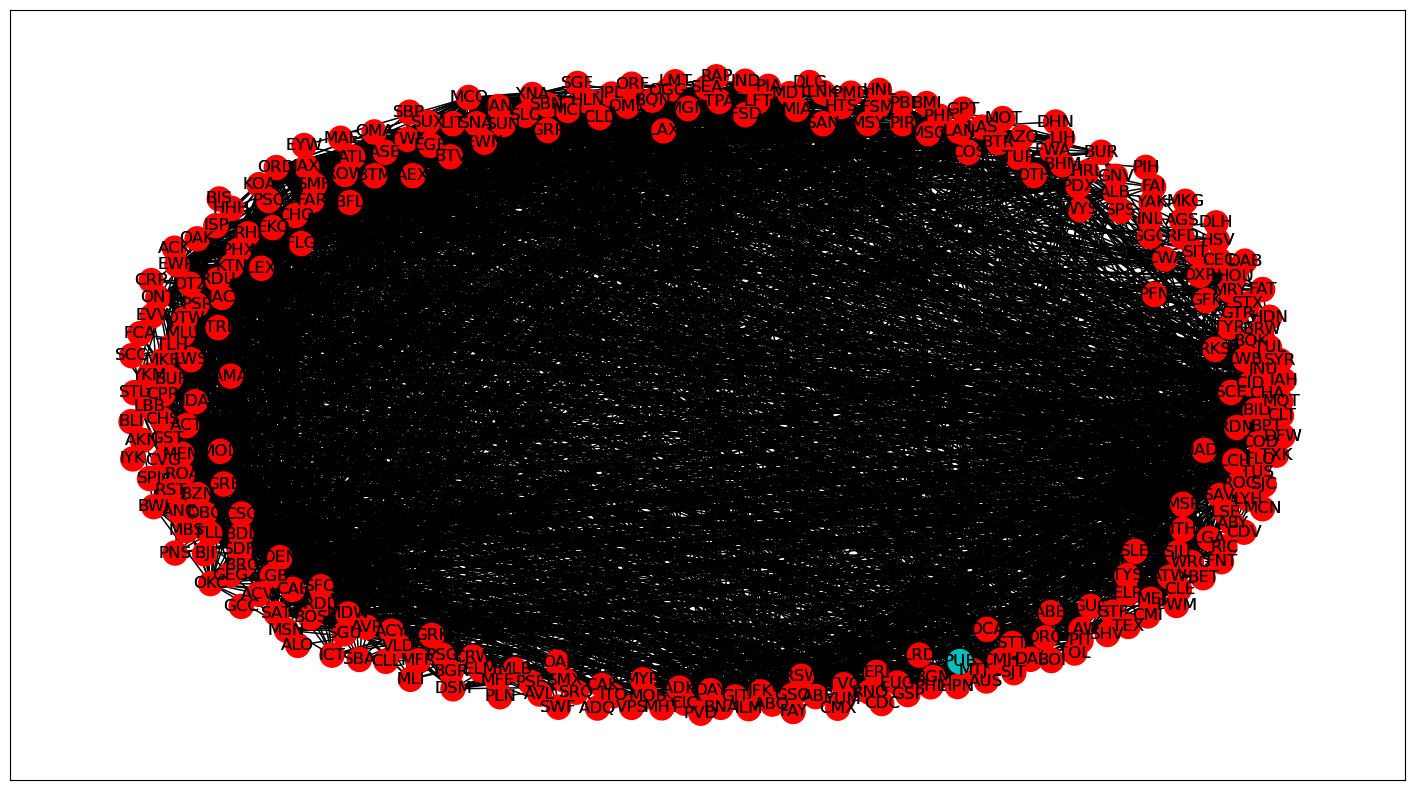

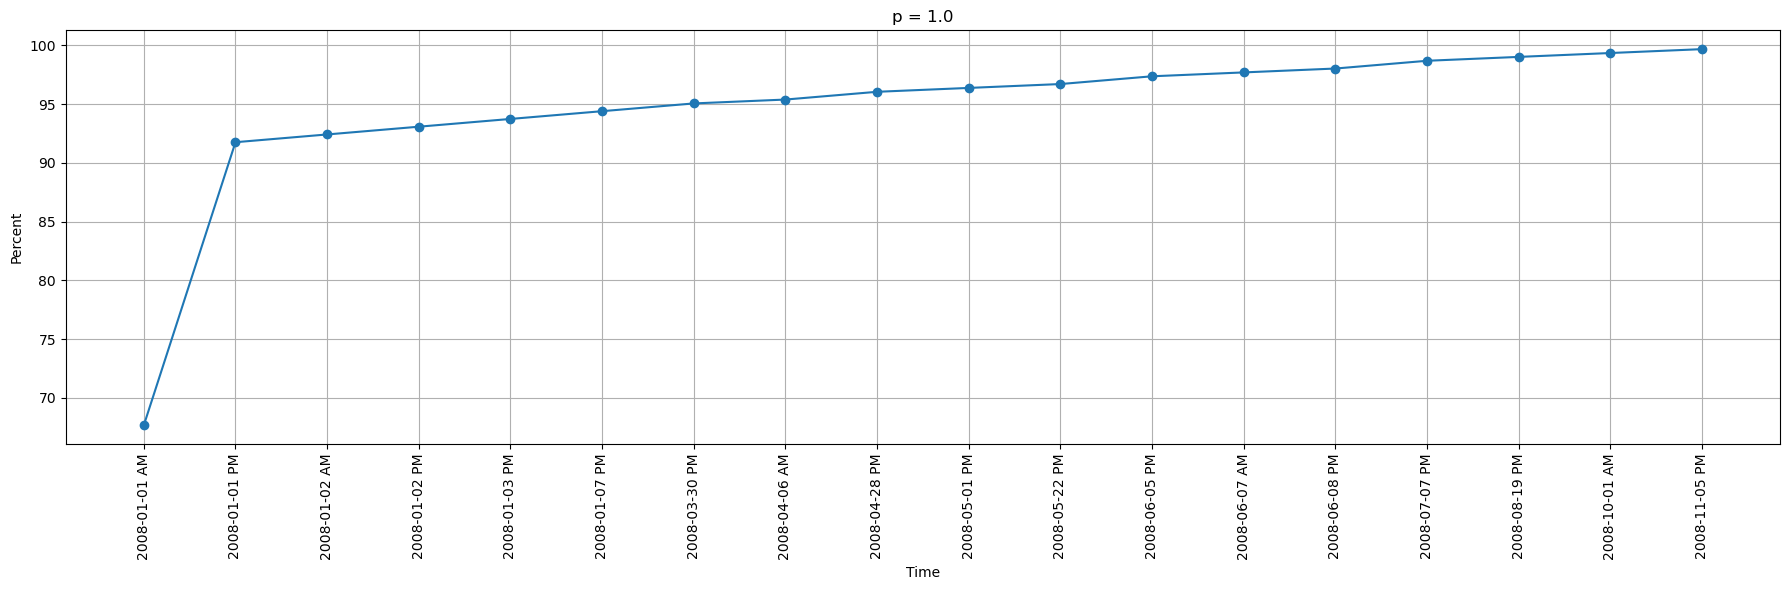

In [6]:
p = 1.
run_multiple_simulation(startCity, epidemicTimeForStartCity, p, step, n)

## Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

### Метрики

Сначала добавим определение процедур и создадим граф.

In [2]:
def construct_graph(p, step=1):
    len_of_df = load_len_of_df('2008_numberOfRecords.txt')
    
    G = create_graph('2008_cityNames.txt')
    print('nodes: ', G.number_of_nodes())

    gen_get_event = get_event('2008_with_date_sorted.csv')

    for _ in tqdm(range(0, len_of_df, step)): # Цикл симуляции
        fly = next(gen_get_event) # выбираем следующую запись из dataset

        add_edge_to_graph(G, fly[0], fly[1], len_of_df)

    return G

In [3]:
G = construct_graph(p=0.5)

nodes:  303


100%|██████████| 6858079/6858079 [01:21<00:00, 84465.27it/s]


### Теперь вычислим кластеризацию

In [24]:
def add_clustering_to_graph(G, feature_name='cluster'):
    for node in G.nodes:
        cluster = nx.clustering(G, node)
        G.nodes[node][feature_name] = cluster


def draw_graph(G, feature_name_for_color):
    clrs = np.array([n[1][feature_name_for_color] for n in G.nodes.data()])

    nx.draw_spring(G, node_color=clrs,
                with_labels=True,\
                alpha=0.7, labels={n: str(n) for n in G.nodes})

In [26]:
add_clustering_to_graph(G)

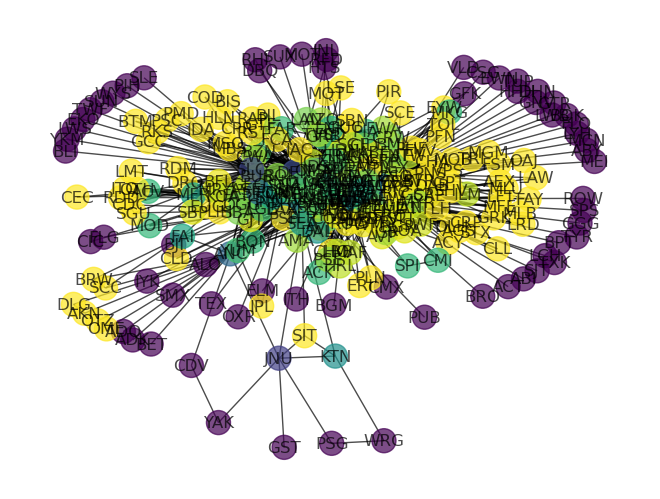

In [27]:
draw_graph(G, 'cluster')

### Степень

In [32]:
def add_degree_centrality_to_graph(G, feature_name='degree_centrality'):
    for node in G.nodes:
        degree = nx.degree(G, node)
        G.nodes[node][feature_name] = degree

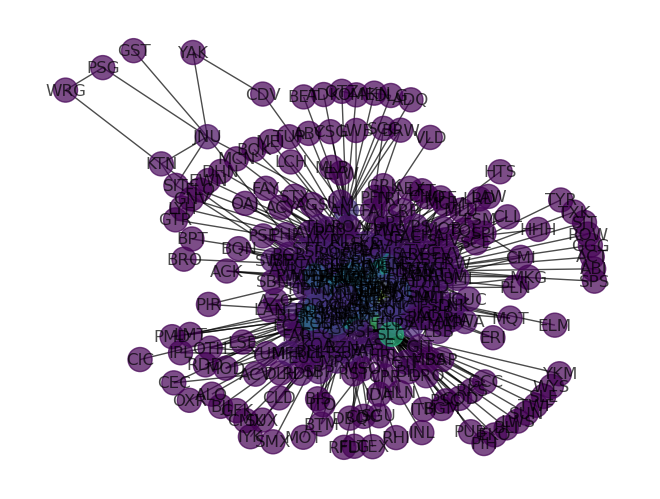

In [33]:
add_degree_centrality_to_graph(G)
draw_graph(G, 'degree_centrality')

### Центральность (nx.betweenness_centrality)

In [42]:
from collections import Counter


def add_betweenness_centrality_to_graph(G, n_most_common=0, feature_name='betweenness_centrality'):
    results = {}
    betweenness_centrality = nx.betweenness_centrality(G)

    for node, centrality in betweenness_centrality.items():
        G.nodes[node][feature_name] = centrality

    if n_most_common > 0:
        betweenness_centrality_counts = Counter(betweenness_centrality)

        for k, v in betweenness_centrality_counts.most_common(n_most_common):
            results[k] = v

    return results

ATL 0.20517914327490655
SLC 0.11361813728790926
DFW 0.10631375167168466
MSP 0.104952938206497
ORD 0.0880406243372284


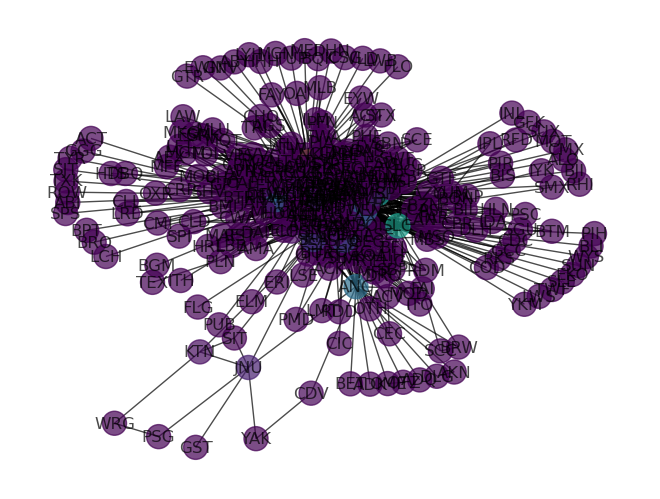

In [43]:
most_common = add_betweenness_centrality_to_graph(G, n_most_common=5)
draw_graph(G, 'betweenness_centrality')
for k, v in most_common.items():
    print(k, v)